# Preprocessing and Modeling

In [50]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle

sns.set_style('darkgrid')
sns.set_palette(palette='colorblind')
np.random.seed(44)
%matplotlib inline

/Users/connie/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Import Data

In [5]:
final_df = pd.read_csv('./data/final_df', na_filter=False)

In [6]:
final_df.drop(columns=['Unnamed: 0'], inplace=True)

In [108]:
final_df.head()

,id,text,label_on-topic,type,processed,tokenized,lemmatized
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,0,hurricane,i've got enough candles to supply a mexican fa...,"['i', 've', 'got', 'enough', 'candles', 'to', ...",i ve got enough candle to supply a mexican family
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,1,hurricane,sandy be soooo mad that she be shattering our ...,"['sandy', 'be', 'soooo', 'mad', 'that', 'she',...",sandy be soooo mad that she be shattering our ...
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,0,hurricane,ibexgirl thankfully hurricane waugh played it ...,"['ibexgirl', 'thankfully', 'hurricane', 'waugh...",ibexgirl thankfully hurricane waugh played it ...
3,'263422851133079552',@taos you never got that magnificent case of B...,0,hurricane,taos you never got that magnificent case of bu...,"['taos', 'you', 'never', 'got', 'that', 'magni...",tao you never got that magnificent case of bur...
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",0,hurricane,"i'm at mad river bar &amp; grille (new york, ny)","['i', 'm', 'at', 'mad', 'river', 'bar', 'amp',...",i m at mad river bar amp grille new york ny


We'll check our target feature `label_on-topic` to make sure our data was imported correctly.

In [121]:
final_df['label_on-topic'].value_counts()

1                                                            21568
0                                                            18495
                                                                 2
&amp; i anit offering that shit to oomf anymore . toodone        1
Name: label_on-topic, dtype: int64

We expect to only see either 1 for `on-topic` or 0 for `off-topic`. We will drop all rows that don't equate to that.

In [7]:
final_df = final_df[(final_df['label_on-topic'] != '') & 
                    (final_df['label_on-topic'] != '&amp; i anit offering that shit to oomf anymore . toodone')]

We will filter our dataframe and arbitrarily choose disaster types to model on. We expect to see the same trends for all disaster types.

In [24]:
final_df['label_on-topic'] = pd.to_numeric(final_df['label_on-topic'])

## Sandy Hurricane

### Model Prep

In [39]:
X = final_df.loc[final_df['type'] == 'hurricane', ['lemmatized']]
y = final_df.loc[final_df['type'] == 'hurricane', ['label_on-topic']]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    random_state=44)

#### TF-IDF

We want to use TF-IDF to determine which words are most discriminating between tweets. Words that occue frequently are penalized and rare words are given more influence in our model. 

We instantiate TfidfVectorizer() and set:
-  `ngram_range = (1, 2)`: Set an upper and lower bound of 1 and 2. Word sequence will contain at least 1 and up to 2 words.
-  `stop_words='english'`: Filter out commonly used words in English
-  `min_df = 25`: Ignore terms that occur in less than 25 documents of the corpus
-  `max_df = 1.0`: There is no maximum threshold since terms cannot have a document frequency greater than `100%`. 

We then create a dataframe that contains each word and its frequency. This is done for both `X_train` and `X_test`.

##### X_train

In [31]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        stop_words='english',
                        min_df=25, 
                        max_df=1.0)
X_train_tfidf = tfidf.fit_transform(X_train['lemmatized'])
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names())

##### Replicate for X_test

In [32]:
X_test_tfidf = tfidf.transform(X_test['lemmatized'])
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names())

In [33]:
X_test_tfidf_df.shape

(2502, 421)

### Modeling

#### Baseline Model

In [44]:
y['label_on-topic'].value_counts(normalize=True)

1    0.613309
0    0.386691
Name: label_on-topic, dtype: float64

Since `on-topic` is our majority class, an accuracy score of 61.33% is our baseline model. If we classify all tweets as being `on-topic`, we will be predicting correctly 61.33% of the time.

#### Random Forest

We will use Random Forest in order to measure feature importance and determine which terms provide the most information gained. 

We instantiate Random Forest Classifier and perform Grid Search to find the most optimal hyperparameters:
-  **n_estimators**: Number of trees our model builds before taking an average of the predictions. 
-  **min_samples_split**: Minimum number of samples required for a node to split
-  **max_depth**: Maximum number of levels in each tree. We include the default value of `None` in addition to our other values.

In [46]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [30, 35, 45],
    'min_samples_split': [2, 3, 5, 7, 10],
    'max_depth': [None, 5, 7, 10]
    
}
gs_rf_sh = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf_sh.fit(X_train_tfidf_df, y_train['label_on-topic'])
print('Score on Training Set:', gs_rf_sh.score(X_train_tfidf_df, y_train['label_on-topic']))
print('Score on Testing Set:', gs_rf_sh.score(X_test_tfidf_df, y_test['label_on-topic']))
gs_rf_sh.best_params_

Score on Training Set: 0.9693578470556888
Score on Testing Set: 0.9248601119104716


{'max_depth': None, 'min_samples_split': 7, 'n_estimators': 45}

-  For `y_train`, we will correctly predict the class in which a tweet belongs in `96.94%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `92.49%` of the time.

##### Takeaways

-  The model is suffering from high varaince, with our training score being rougly `4.45%` higher than our test score. 
-  The accuracy scores are greater than our baseline model of `61.33%`.

##### Important Features

In [47]:
feat_importance = pd.DataFrame(gs_rf_sh.best_estimator_.feature_importances_, X_train_tfidf_df.columns, columns=['importance'])

In [48]:
top_feat = feat_importance.sort_values('importance', ascending=False).head(20)

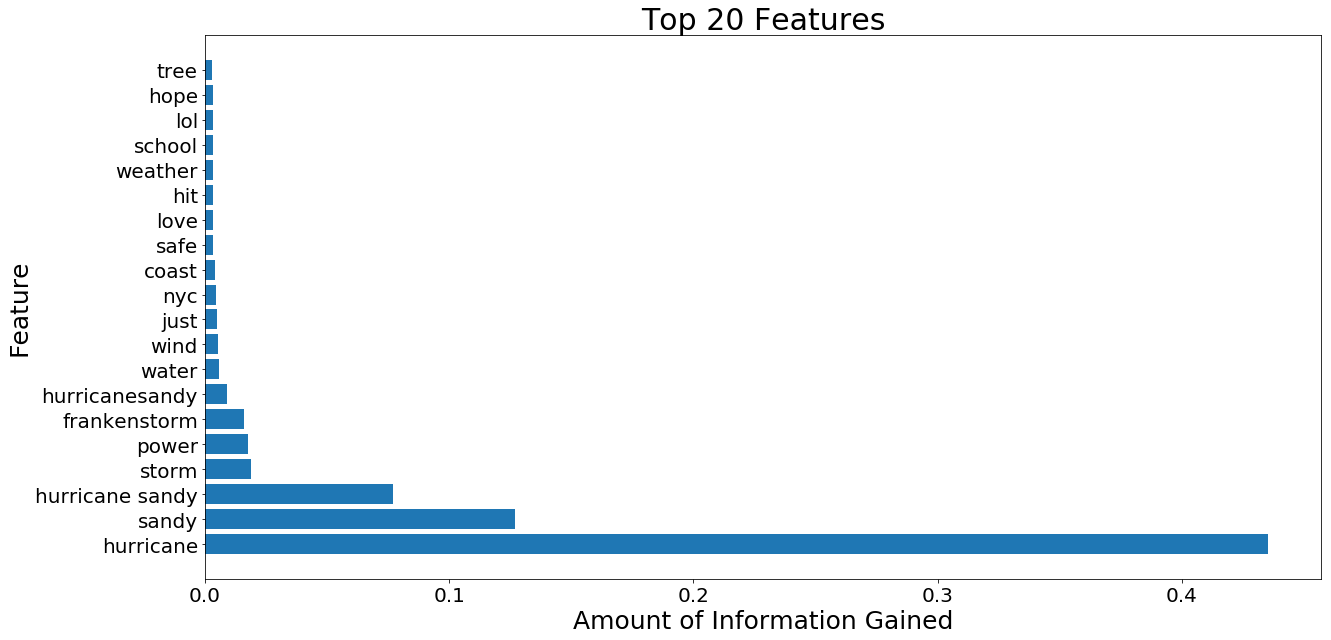

In [49]:
plt.figure(figsize=(20,10))
plt.barh(top_feat.index, top_feat['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  Terms with the most information gained are either referring to the disaster type (`hurricane`) or the name itself.
-  Words like `safe`, `love`, and`hope` are most likely from well-wishers not affected by the disaster.

## Oklahoma Tornado

### Model Prep

In [35]:
X = final_df.loc[final_df['type'] == 'tornado', ['lemmatized']]
y = final_df.loc[final_df['type'] == 'tornado', ['label_on-topic']]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    random_state=44)

#### TF-IDF

We instantiate TfidfVectorizer() and set the same parameters as before.

##### X_train

In [37]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        stop_words='english',
                        min_df=25, 
                        max_df=1.0)
X_train_tfidf = tfidf.fit_transform(X_train['lemmatized'])
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names())

##### Replicate for X_test

In [38]:
X_test_tfidf = tfidf.transform(X_test['lemmatized'])
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names())

In [39]:
X_test_tfidf_df.shape

(2498, 460)

### Modeling

#### Baseline Model

In [41]:
y['label_on-topic'].value_counts(normalize=True)

0    0.516865
1    0.483135
Name: label_on-topic, dtype: float64

`on-topic` is our majority class again, with a similar imbalance as Alberta Floods and Queensland Flood. If we classify all tweets as being `on-topic`, we will be predicting correctly 53.84% of the time.

In [43]:
lr = LogisticRegression()
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'penalty' : ['l1','l2']   
}
gs_lr_ot = GridSearchCV(lr, param_grid = lr_params, scoring = 'roc_auc', cv = 3)
gs_lr_ot.fit(X_train_tfidf_df, y_train['label_on-topic'])
print('Score on Training Set:', gs_lr_ot.score(X_train_tfidf_df, y_train['label_on-topic']))
print('Score on Testing Set:', gs_lr_ot.score(X_test_tfidf_df, y_test['label_on-topic']))
gs_lr_ot.best_params_

Score on Training Set: 0.9827200422816696
Score on Testing Set: 0.9728343634504893


{'C': 10, 'penalty': 'l2'}

##### Odds

In [46]:
lr_ot_odds = pd.DataFrame(gs_lr_ot.best_estimator_.coef_, columns = X_train_tfidf_df.columns).T
lr_ot_odds.columns = ['weights']
lr_ot_odds['odds'] = np.exp(lr_ot_odds['weights'])
lr_ot_odds['abs_weights'] = np.abs(lr_ot_odds['weights'])
lr_ot_odds.sort_values(by='abs_weights', ascending=False).head(20)

,weights,odds,abs_weights
tornado,11.912247,149081.242683,11.912247
prayforoklahoma,9.116243,9101.945458,9.116243
prayer,8.688857,5936.390772,8.688857
oklahoma,8.001383,2985.082724,8.001383
devastation,7.722705,2259.062673,7.722705
donation,6.443826,628.808033,6.443826
victim,6.373741,586.247165,6.373741
redcross,6.160988,473.896250,6.160988
donating,5.720924,305.186724,5.720924
disaster,5.567559,261.794211,5.567559


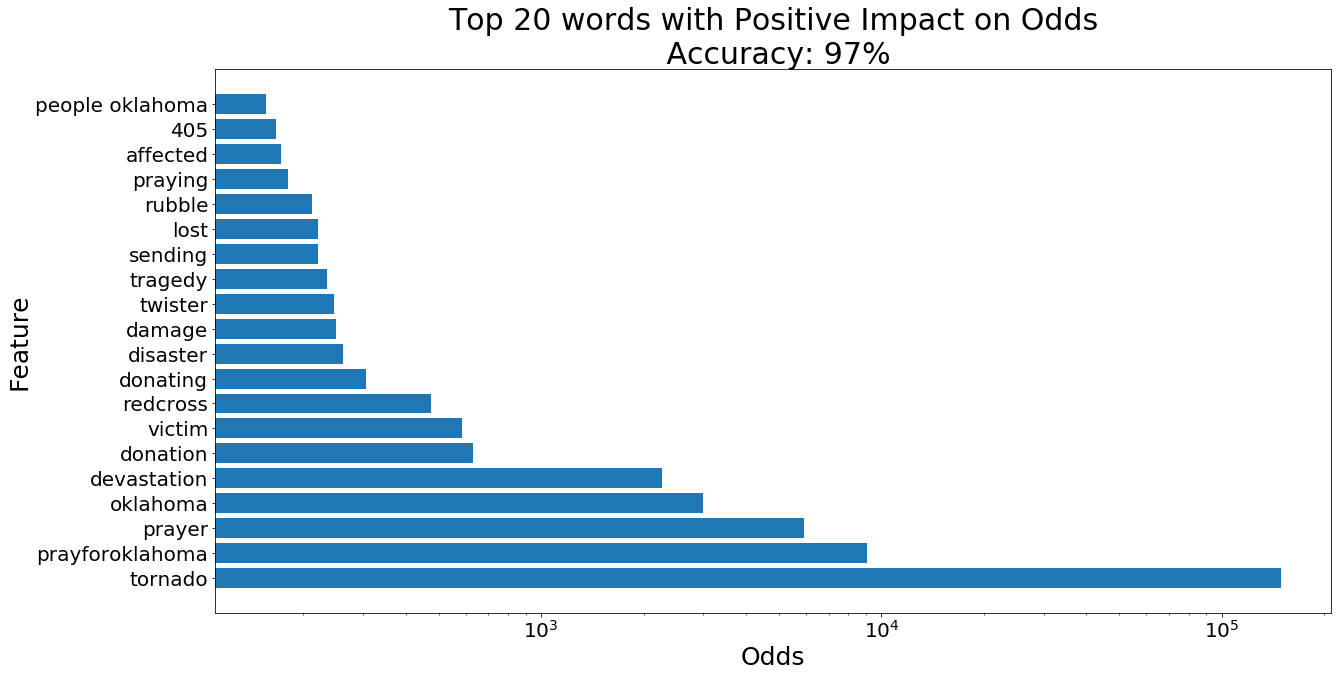

In [47]:
plt.figure(figsize=(20,10))
plt.barh(lr_ot_odds.sort_values(by='odds', ascending=False).head(20).index, 
         lr_ot_odds.sort_values(by='odds', ascending=False).head(20)['odds'],
         log=True)
plt.title('Top 20 words with Positive Impact on Odds\n Accuracy: 97%', fontsize=30)
plt.xlabel('Odds', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## Alberta Floods and Queensland Flood

We repeat the same process for disaster type `flood` (Alberta and Queensland).

### Model Prep

In [50]:
X = final_df.loc[final_df['type'] == 'flood', ['lemmatized']]
y = final_df.loc[final_df['type'] == 'flood', ['label_on-topic']]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    random_state=44)

#### TF-IDF

We instantiate TfidfVectorizer() and set the same parameters as before.

##### X_train

In [52]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        stop_words='english',
                        min_df=25, 
                        max_df=1.0)
X_train_tfidf = tfidf.fit_transform(X_train['lemmatized'])
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names())

##### Replicate for X_test

In [53]:
X_test_tfidf = tfidf.transform(X_test['lemmatized'])
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names())

In [54]:
X_test_tfidf_df.shape

(5016, 1060)

### Modeling

#### Baseline Model

In [55]:
y['label_on-topic'].value_counts(normalize=True)

1    0.528459
0    0.471541
Name: label_on-topic, dtype: float64

`on-topic` is our majority class again, but we do not see as great of an imbalance as we did with Sandy Hurricane. If we classify all tweets as being `on-topic`, we will be predicting correctly 52.85% of the time.

#### Random Forest

In [56]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [30, 35, 45],
    'min_samples_split': [2, 3, 5, 7, 10],
    'max_depth': [None, 5, 7, 10]
    
}
gs_rf_fl = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf_fl.fit(X_train_tfidf_df, y_train['label_on-topic'])
print('Score on Training Set:', gs_rf_fl.score(X_train_tfidf_df, y_train['label_on-topic']))
print('Score on Testing Set:', gs_rf_fl.score(X_test_tfidf_df, y_test['label_on-topic']))
gs_rf_fl.best_params_

Score on Training Set: 0.9855794790005317
Score on Testing Set: 0.9595295055821371


{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 35}

-  For `y_train`, we will correctly predict the class in which a tweet belongs in `98.56%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `95.95%` of the time.

##### Important Features

In [57]:
feat_importance = pd.DataFrame(gs_rf_fl.best_estimator_.feature_importances_, X_train_tfidf_df.columns, columns=['importance'])

In [58]:
top_feat = feat_importance.sort_values('importance', ascending=False).head(20)

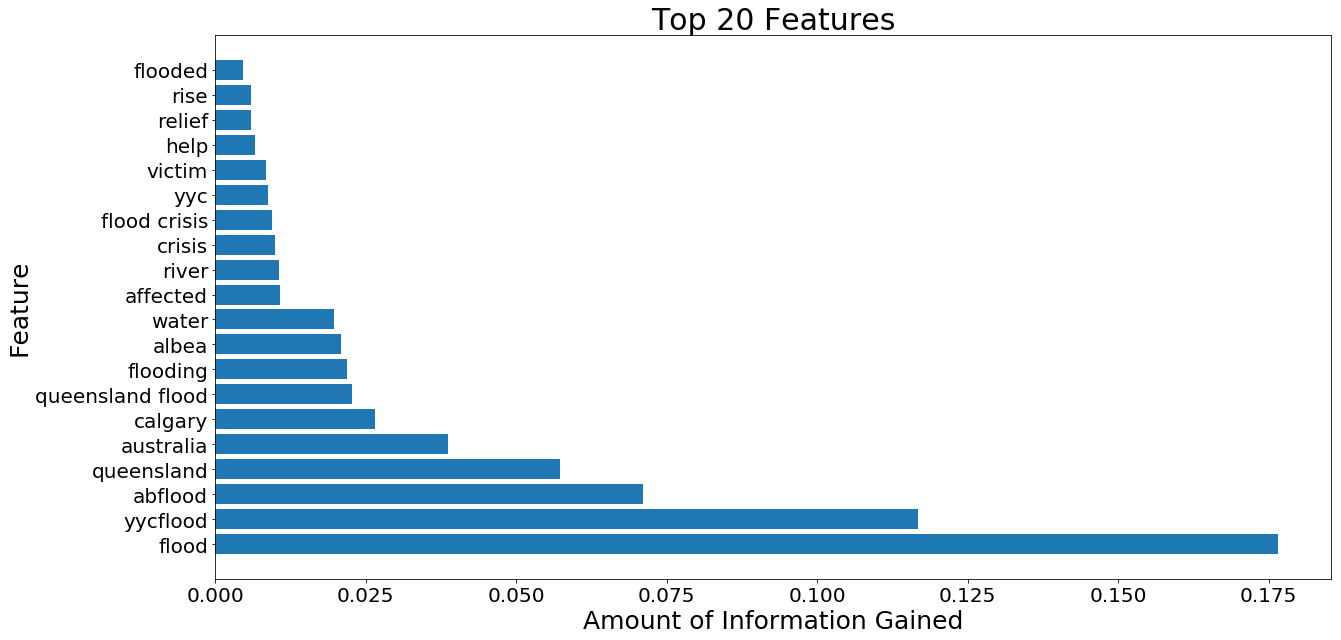

In [59]:
plt.figure(figsize=(20,10))
plt.barh(top_feat.index, top_feat['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  Similar to what we saw with Sandy Hurricane, the words with the most information gained are either referring to the disaster type (`flood`) or the name directly.
-  There are several terms that refer to the flood location: `yycflood`, `queensland`, `calgary`, and `albea`.

#### Logistic Regression

In [51]:
lr = LogisticRegression()
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'penalty' : ['l1','l2']   
}
gs_lr_fl = GridSearchCV(lr, param_grid = lr_params, scoring = 'roc_auc', cv = 3)
gs_lr_fl.fit(X_train_tfidf_df, y_train['label_on-topic'])
print('Score on Training Set:', gs_lr_fl.score(X_train_tfidf_df, y_train['label_on-topic']))
print('Score on Testing Set:', gs_lr_fl.score(X_test_tfidf_df, y_test['label_on-topic']))
gs_lr_fl.best_params_

Score on Training Set: 0.9827200422816696
Score on Testing Set: 0.9728343634504893


{'C': 10, 'penalty': 'l2'}

##### Odds

In [53]:
lr_fl_odds = pd.DataFrame(gs_lr_fl.best_estimator_.coef_, columns = X_train_tfidf_df.columns).T
lr_fl_odds.columns = ['weights']
lr_fl_odds['odds'] = np.exp(lr_fl_odds['weights'])
lr_fl_odds['abs_weights'] = np.abs(lr_fl_odds['weights'])
lr_fl_odds.sort_values(by='abs_weights', ascending=False).head(20)

,weights,odds,abs_weights
tornado,11.912247,149081.242683,11.912247
prayforoklahoma,9.116243,9101.945458,9.116243
prayer,8.688857,5936.390772,8.688857
oklahoma,8.001383,2985.082724,8.001383
devastation,7.722705,2259.062673,7.722705
donation,6.443826,628.808033,6.443826
victim,6.373741,586.247165,6.373741
redcross,6.160988,473.896250,6.160988
donating,5.720924,305.186724,5.720924
disaster,5.567559,261.794211,5.567559


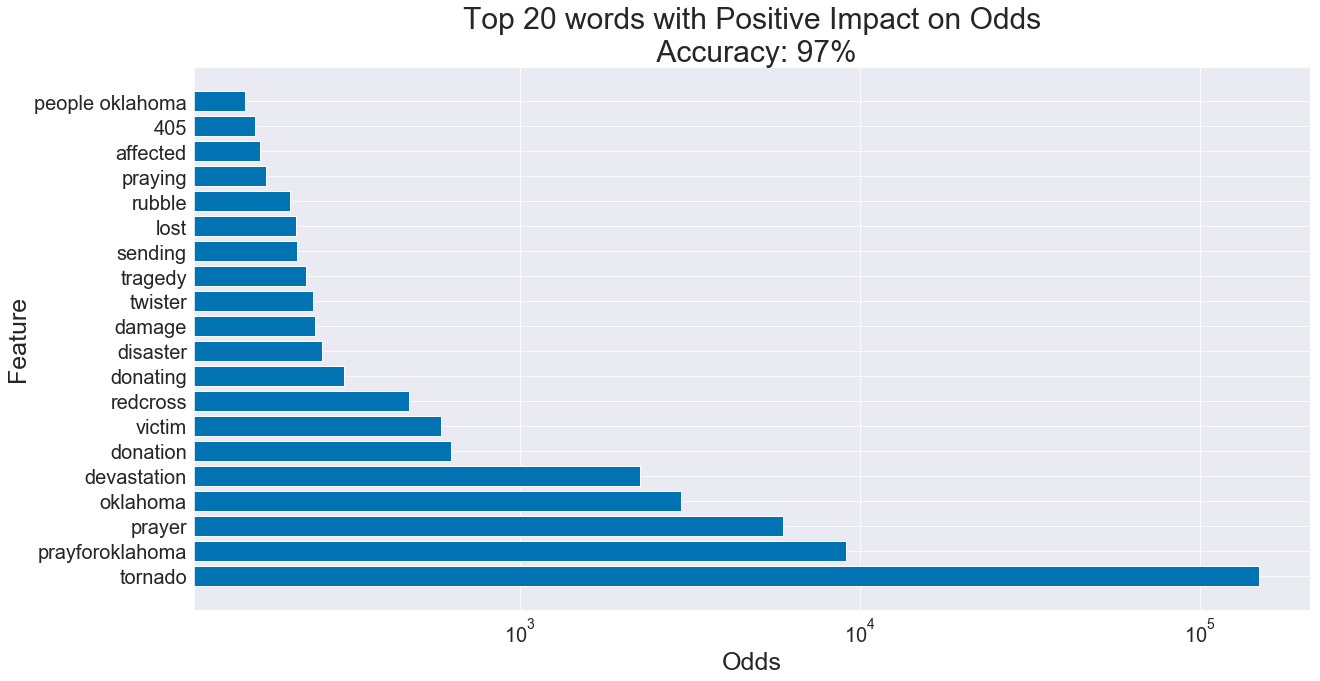

In [54]:
plt.figure(figsize=(20,10))
plt.barh(lr_fl_odds.sort_values(by='odds', ascending=False).head(20).index, 
         lr_fl_odds.sort_values(by='odds', ascending=False).head(20)['odds'],
         log=True)
plt.title('Top 20 words with Positive Impact on Odds\n Accuracy: 97%', fontsize=30)
plt.xlabel('Odds', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## All Disasters

Now, we'll model on the entire dataset to determine which words have the most information gained. The process will be the same as our prior two models.

### Model Prep

In [25]:
X = final_df[['lemmatized']]
y = final_df['label_on-topic']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    random_state=44)

#### TF-IDF

We instantiate TfidfVectorizer() and set the same parameters as before.

##### X_train

In [27]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        stop_words='english',
                        min_df=25, 
                        max_df=1.0)
X_train_tfidf = tfidf.fit_transform(X_train['lemmatized'])
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names())

##### Replicate for X_test

In [28]:
X_test_tfidf = tfidf.transform(X_test['lemmatized'])
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names())

In [29]:
X_test_tfidf_df.shape

(10016, 1874)

### Modeling

#### Baseline Model

In [136]:
y.value_counts(normalize=True)

1    0.538352
0    0.461648
Name: label_on-topic, dtype: float64

`on-topic` is our majority class again, with a similar imbalance as Alberta Floods and Queensland Flood. If we classify all tweets as being `on-topic`, we will be predicting correctly 53.84% of the time.

#### Random Forest

In [137]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [30, 35, 45],
    'min_samples_split': [2, 3, 5, 7, 10],
    'max_depth': [None, 5, 7, 10]
    
}
gs_rf_all = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf_all.fit(X_train_tfidf_df, y_train)
print('Score on Training Set:', gs_rf_all.score(X_train_tfidf_df, y_train))
print('Score on Testing Set:', gs_rf_all.score(X_test_tfidf_df, y_test))
gs_rf_all.best_params_

Score on Training Set: 0.9882517389423237
Score on Testing Set: 0.9441892971246006


{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 35}

-  For `y_train`, we will correctly predict the class in which a tweet belongs in `98.83%` of the time.
-  For `y_test`, we will correctly predict the class in which a tweet belongs in `94.42%` of the time.

##### Important Features

In [138]:
feat_importance = pd.DataFrame(gs_rf_all.best_estimator_.feature_importances_, X_train_tfidf_df.columns, columns=['importance'])

In [139]:
top_feat = feat_importance.sort_values('importance', ascending=False).head(20)

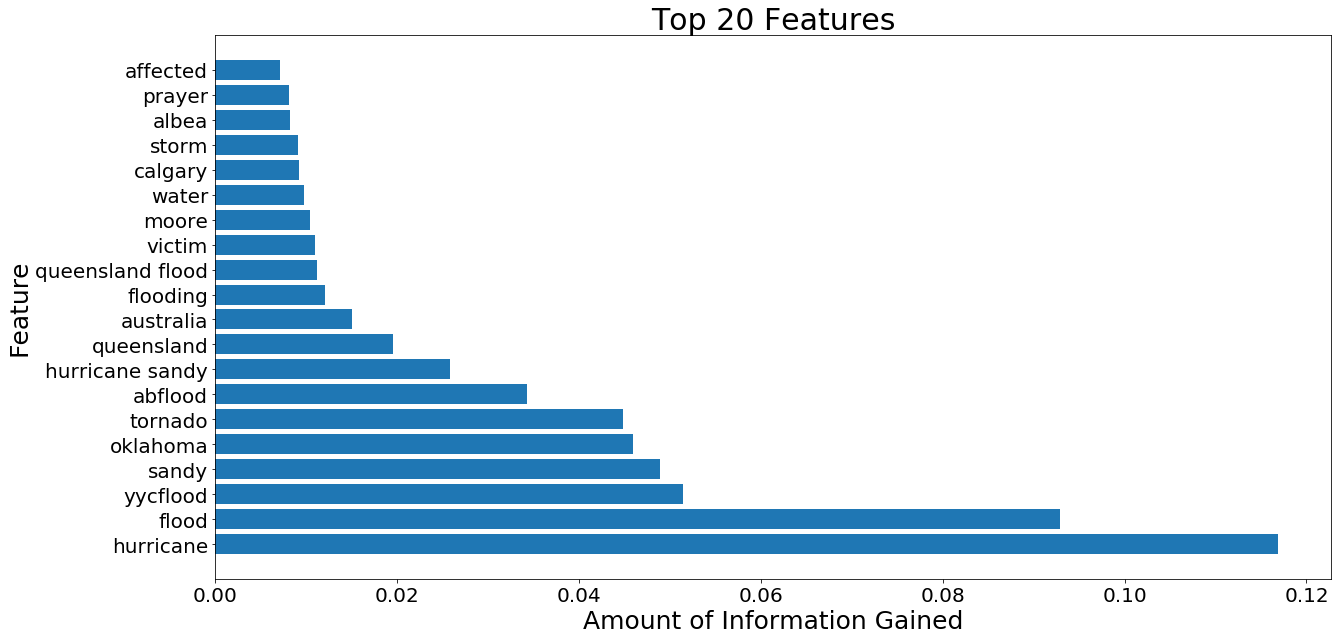

In [140]:
plt.figure(figsize=(20,10))
plt.barh(top_feat.index, top_feat['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

-  As expected, we see a lot of overlap between the top features here and our prior two models. 
-  Given that we're looking across three different disaster types, the information gained for terms relating to the disaster name and type is less than before.
-  For any disaster, the strongest indicator of whether a tweet is on-topic or off-topic will be the disaster type and name.

#### Logistic Regression

In [30]:
lr = LogisticRegression()
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'penalty' : ['l1','l2']   
}
gs_lr_all = GridSearchCV(lr, param_grid = lr_params, scoring = 'roc_auc', cv = 3)
gs_lr_all.fit(X_train_tfidf_df, y_train)
print('Score on Training Set:', gs_lr_all.score(X_train_tfidf_df, y_train))
print('Score on Testing Set:', gs_lr_all.score(X_test_tfidf_df, y_test))
gs_lr_all.best_params_

Score on Training Set: 0.9833853599875809
Score on Testing Set: 0.980313110445566


{'C': 1, 'penalty': 'l2'}

##### Odds

In [32]:
lr_all_odds = pd.DataFrame(gs_lr_all.best_estimator_.coef_, columns = X_train_tfidf_df.columns).T
lr_all_odds.columns = ['weights']
lr_all_odds['odds'] = np.exp(lr_all_odds['weights'])
lr_all_odds['abs_weights'] = np.abs(lr_all_odds['weights'])
lr_all_odds.sort_values(by='abs_weights', ascending=False).head(20)

,weights,odds,abs_weights
flood,17.290440,3.229554e+07,17.290440
hurricane,16.912719,2.213607e+07,16.912719
yycflood,12.013164,1.649114e+05,12.013164
abflood,10.589337,3.970917e+04,10.589337
tornado,10.304200,2.985776e+04,10.304200
sandy,9.859402,1.913745e+04,9.859402
oklahoma,7.998711,2.977119e+03,7.998711
flooding,7.911237,2.727762e+03,7.911237
frankenstorm,6.241974,5.138717e+02,6.241974
storm,6.116661,4.533484e+02,6.116661


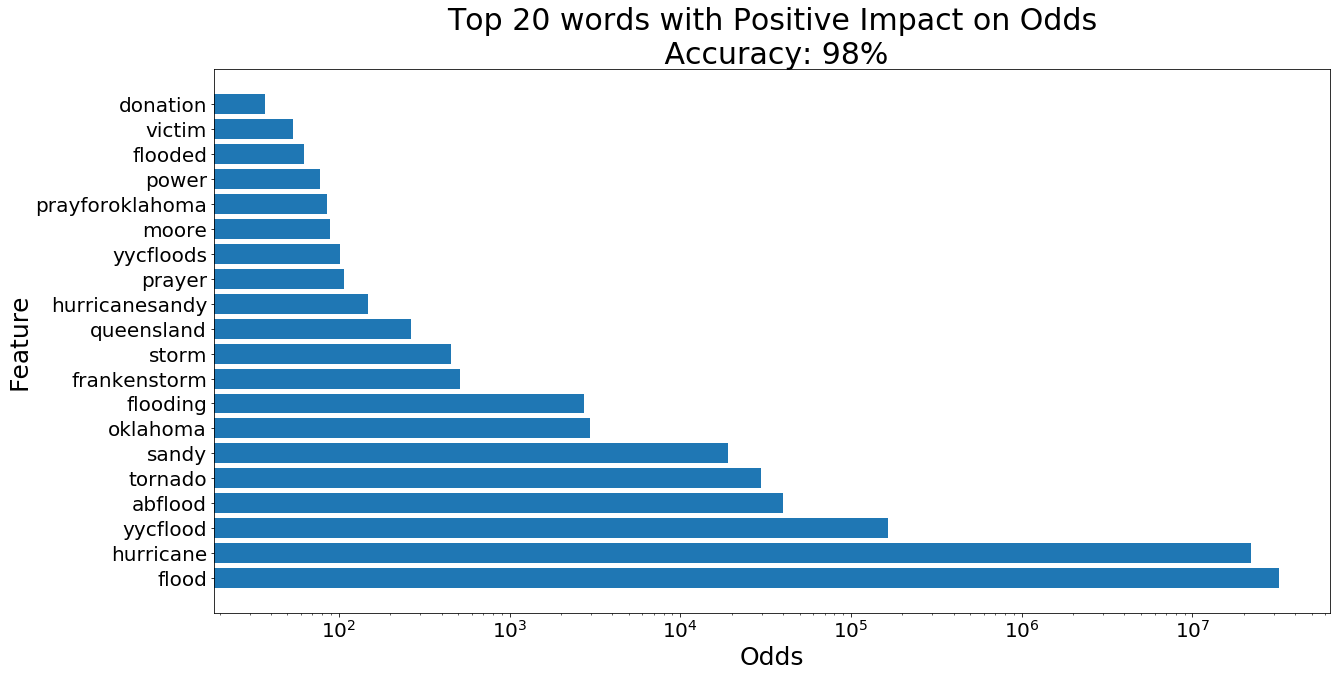

In [34]:
plt.figure(figsize=(20,10))
plt.barh(lr_all_odds.sort_values(by='odds', ascending=False).head(20).index, 
         lr_all_odds.sort_values(by='odds', ascending=False).head(20)['odds'],
         log=True)
plt.title('Top 20 words with Positive Impact on Odds\n Accuracy: 98%', fontsize=30)
plt.xlabel('Odds', fontsize=25)
plt.ylabel('Feature', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

## Pickle Models for Future Predictions

In [145]:
with open('./assets/rf_flood.pkl', 'wb+') as f:
    pickle.dump(gs_rf_fl, f)

In [146]:
with open('./assets/rf_all.pkl', 'wb+') as f:
    pickle.dump(gs_rf_all, f)

In [57]:
with open('./assets/rf_hurricane.pkl', 'wb+') as f:
    pickle.dump(gs_rf_sh, f)

NameError: name 'gs_rf_sh' is not defined

In [56]:
with open('./assets/lr_flood.pkl', 'wb+') as f:
    pickle.dump(gs_lr_fl, f)

In [31]:
with open('./assets/lr_all.pkl', 'wb+') as f:
    pickle.dump(gs_lr_all, f)

In [48]:
with open('./assets/lr_tornado.pkl', 'wb+') as f:
    pickle.dump(gs_lr_ot, f)